# **Licence Plate : Anti-Z**

**Aim**

To build a program that reads and recognises licence plates from the image of the car, taken from CCTV cameras. Our main research question is whether we can recognise the licence plates of the car given that we have an image of the car with licence plates on it.

**Context and Problem**

Licence Plate Recognition helps to identify the owner of the car, thus it has numerous applications. For instance, it can be used to solve the problem of breaking the speed limit, or checking whether the given car can enter the restricted area. Considering the fact that there are lots of russian occupants on the roads sticking letter "Z" to their car, we can track them and blow them up!

Licence Plate Recognition can be used during the war: in the first days of full-scale invasion, there were reports that some people in the cars were on the highways putting marks for aviation. Identifying such cars is extremely important, that’s the reason why we decided to try to implement the solution.

**Solution Method**

There are many types of algorithms that recognize car numbers in a photo. But all of them have the same basic steps: first, you need to prepare a picture, then find the needed contours and, based on the results, using different approaches, look for a car number. The search for contours can be done by different algorithms based on what contours will be needed in the future. We will use the Canny edge detector in our algorithm, which we will talk about later, and explain why we chose it. But there are algorithms in which developers are interested only in horizontal or only vertical contours, so they use motion segmentation and Sobel Edge Detector. We have chosen our algorithm because we found it the easiest and most understandable for us. 

**Pros and Cons**

Cons:


*   Due to the fact that we are looking for contours that have a shape similar to a rectangle and assume that these are the car license, if there is another rectangular object in the frame, it is possible that we choose it instead of the correct one.

*   If there is more than one car in the picture, we can only find the numbers of one car.




Pros:

*   Easy to understand and explain
*   Easy implementation


Generally our algorithm consists of 6 main steps: 

1) resizing our image

2) image grayscaling 

3) deleting noises from the image 

4) finding all main contours 

5) choosing the 30 largest contours 

6) choosing the largest rectangular contour - assume it to be licence plate

7) recognize text on the license plate


In [1]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import cv2
import imutils
import pytesseract
from google.colab.patches import cv2_imshow
import numpy as np
import math

**Resizing**

We know that our image is represented as three matrices. Matrix for red, green, and blue (RGB) color. So if we want to resize it, we will use properties that we can apply to matrices.
If we want to resize the matrix, we can use the scaling matrix and multiply it on ours. To resize it, we only need to calculate coefficients on which x and y should be multiplied.

In our case, the image is a 2d space, so our matrix will be 3x3.

$$x_{coef} = \frac{width_{needed}}{width_{current}}$$

$$y_{coef} = \frac{height_{needed}}{height_{current}}$$

$$S_vp = \begin{bmatrix}
v_x & 0 & 0 \\
0 & v_y & 0 \\
0 & 0 & 1 
\end{bmatrix} \begin{bmatrix}
p_x \\
p_y \\
1 
\end{bmatrix} = \begin{bmatrix}
v_xp_x \\
v_yp_y \\
1 
\end{bmatrix}$$

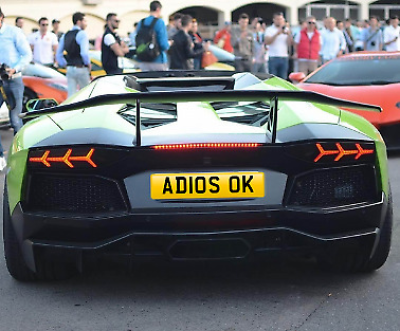

In [3]:
image = cv2.imread('test10.jpg')
image = imutils.resize(image, width=400)
cv2_imshow(image)

**Image grayscaling**

Grayscaling is a very simple task, because we only have one formula, which should be used to transform an RGB image to grayscale. 

Logically we should have transforming formula like this :

$$Y = 0.333 * R + 0.333* G + 0.333* B$$

But we have to weight every channel  differently to account for how much color we perceive each:

$$Y = 0.299 * R + 0.587* G + 0.114* B$$

We have this formula because people perceive different colors with different sensitivities, which is why the coefficients of each color must be different.

So as we have our image saved as 3 matrices of colors (red, green, blue), we have to multiply each of these matrices by their coefficients and sum them up. The result will be our grayscale image.

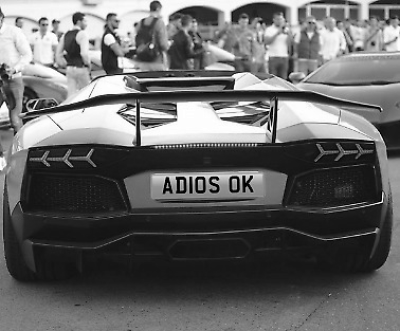

In [4]:
grey_image = image.copy()
rows, cols = grey_image.shape[0:2]
width = len(image[0])
height = len(image)
newg_img = [ [0 for _ in range(width)] for _ in range(height) ]


for row_idx in range(rows):
    for col_idx in range(cols):
        newg_img[row_idx][col_idx] = grey_image[row_idx][col_idx][0] * 0.299 + grey_image[row_idx][ col_idx][1] * 0.587 + grey_image[row_idx][ col_idx][2] * 0.114 

grey_image = np.array(newg_img)
cv2_imshow(grey_image)

**Deleting noises from the image**

We are interested in removing unnecessary noise from the photo, because the smooth surface of the machine can often reflect various objects that we do not want to take into account.

The first thing that comes to mind when we need to remove unnecessary noise from a photo is the usual blurring. In which we take the square of points around the desired pixel and calculate the average value from them.

Let us try that.

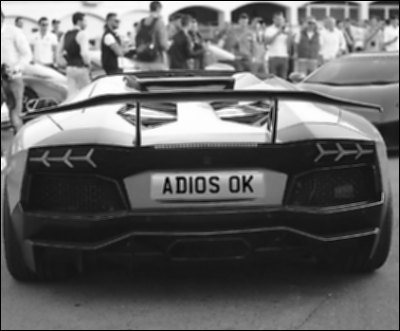

In [5]:
width = len(image[0])
height = len(image)

steps = [(-1, -1), (0,-1), (1,-1), 
         (-1,  0), (0, 0), (1, 0),
         (-1,  1), (0, 1), (1, 1)]

new_img = [ [0 for _ in range(width)] for _ in range(height) ]

for y in range(1, height - 1):
  for x in range(1, width - 1):
    cur_pix = 0
    for step in steps:
      cur_pix += grey_image[y + step[1]][x + step[0]]
    cur_pix /= 9
    new_img[y][x] = cur_pix

new_img = np.array(new_img)
# print(new_img)
cv2_imshow(new_img)


This option is quite bad, because although it removes noise, it degrades the picture quality. And because of this, we lose the sharpness of the contours we are looking for.


**Gaussian Filtering**

Another option for removing noise may be Gaussian Filtering.

Gaussian filtering is the weighted average of the intensity of adjacent positions with decreasing weight together with the spatial distance to the central position.

In simple words - the farther the point is, the less it affects the current point.

Gaussian Blur (GB) has the following formula:

$$GB[i]_p = \sum\limits_{q \in S} G_{\sigma}(\|p-q\|)I_q$$


Where:

p, q - positions of pixels

I - denotes Image

Gσ(x) - denotes the two-dimensional Gaussian kernel, that decreases the influence of distant pixels.

$$G_{\sigma}(x) = \frac{1}{2\pi\sigma^2}exp({-\frac{x^2}{2\sigma^2}})$$


The distance is defined by Gσ(||p−q||), where σ is a parameter defining the extension of the neighborhood the size of the neighborhood.

This filtering is better than regular blurring, but still is not perfect. The problem with such a filter is that it only takes into account the distance of the points, but does not take into account their color intensity, or that the pixel can be edge pixel. 

The result is, it blurs the edges as well, which we do not want to happen since it takes away crucial details from the image.

# **Bilateral Filter**

Bilateral filtering also takes a Gaussian filter in space, but additionally considers one more Gaussian filter which is a function of pixel difference.

The Gaussian function of space takes into account only the distance between points, which means that only those points that are close to the desired one are taken into account.

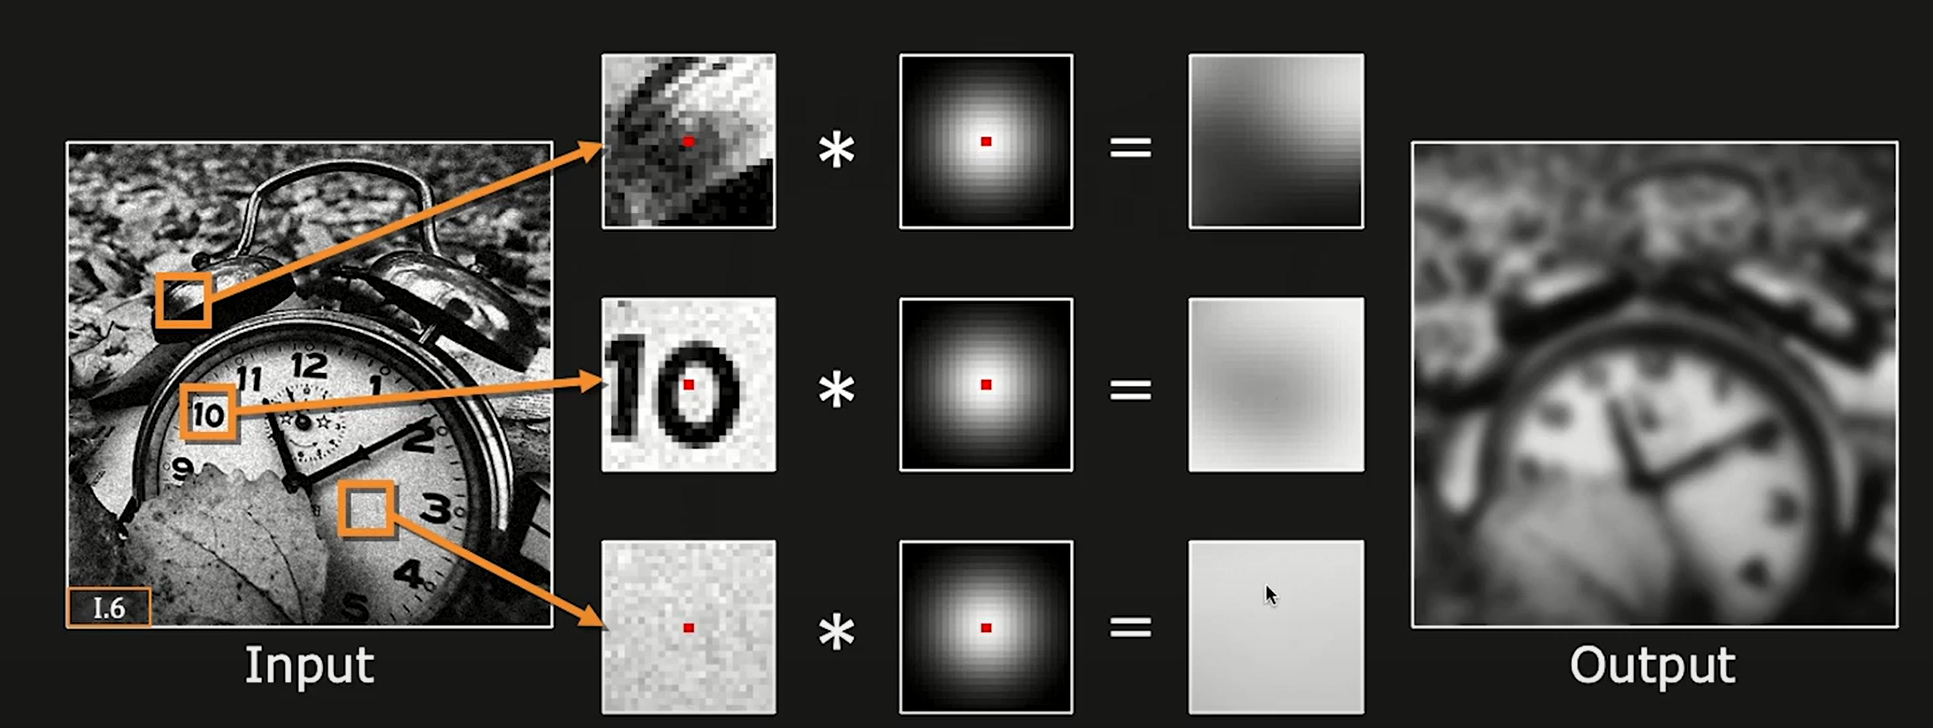

When the Gaussian function of intensity difference takes into account only those points that have a saturation similar to the central point.

So it preserves the edges since pixels at edges will have large intensity variation.


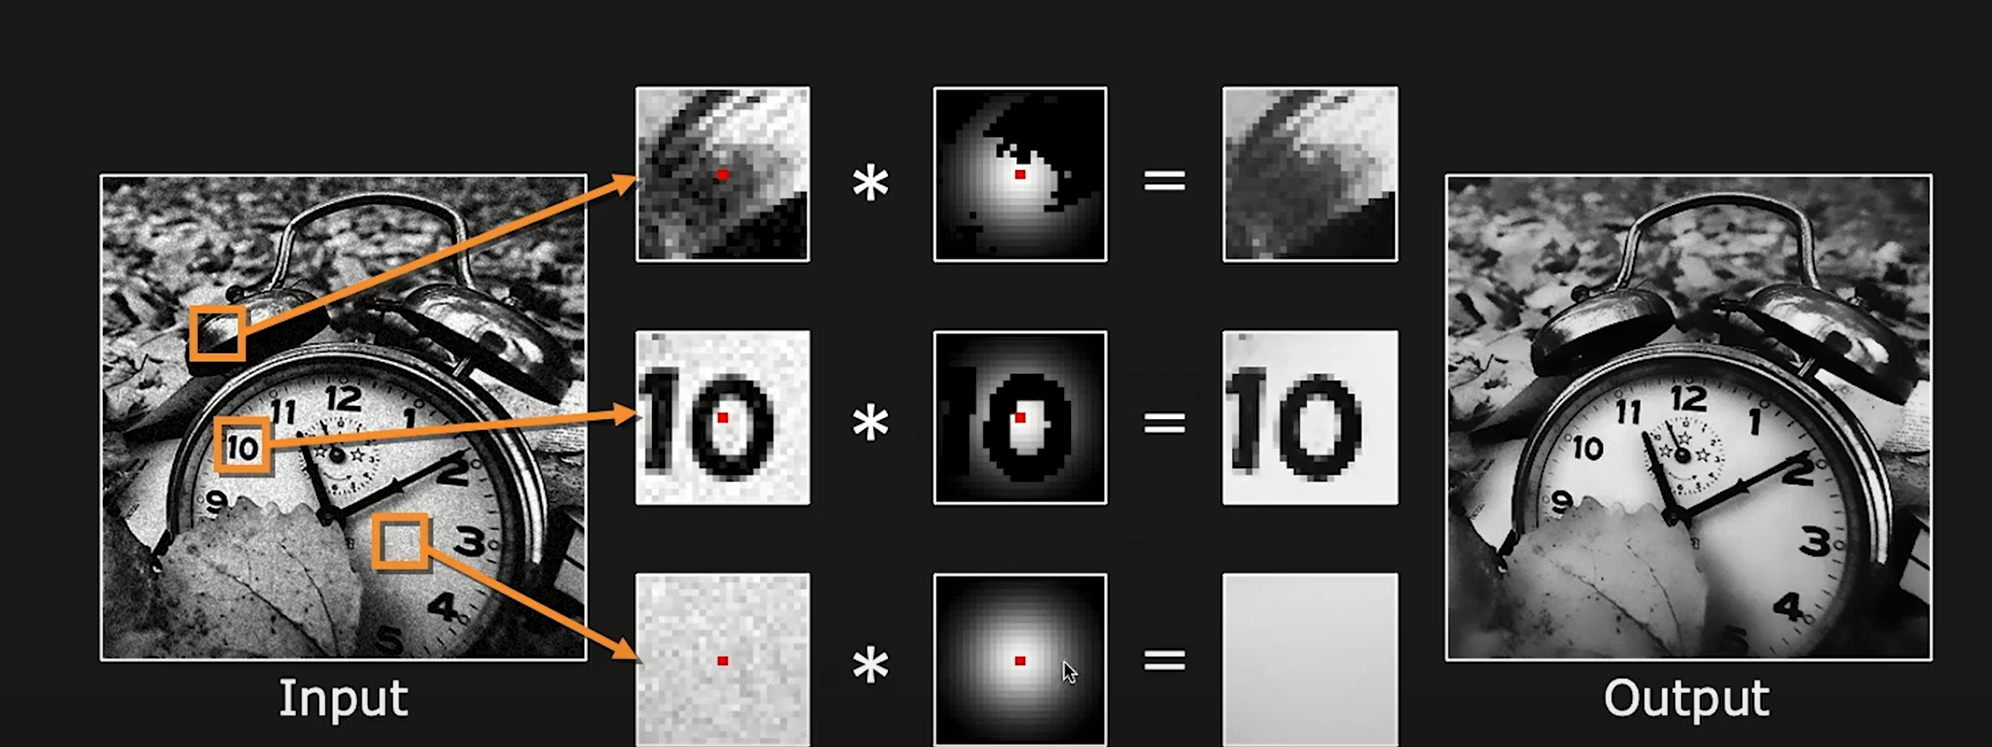


The important point which is considered in Bilateral filtering is that the two pixels are close to each other not only if they occupy nearby spatial locations but also if they have some similarity in the photometric range.

Bilateral Filter (BF) is give by the following formula:

$$BF[I]_p=\frac{1}{W_p}\sum\limits_{q \in S}G_{\sigma_s}(\|p-q\|)G_{\sigma_r}(I_p-I_q)I_q$$


So, as we can see that is GB formula with added normalization factor (Wp) and Gσs , that decreases influence of pixels, which have intensity value different from our needed point.


Where:

Wp - is a normalization factor
$$W_p=\sum\limits_{q \in S}G_{\sigma_s}(\|p-q\|)G_{\sigma_r}(I_p-I_q)$$

Gσs(x) - denotes the two-dimensional Gaussian kernel, that decreases the influence of distant pixels.

Gσr(x) - is a range Gaussian that decreases the influence of pixels q with an intensity value different from Ip.

σs - are the space parameter

σr - are the range parameter.

**The bilateral filter is controlled by two parameters: σs and σr**

- If range parameter σr increases, the bilateral filter becomes closer to Gaussian blur

- Increasing the spatial parameter σs smooths larger features

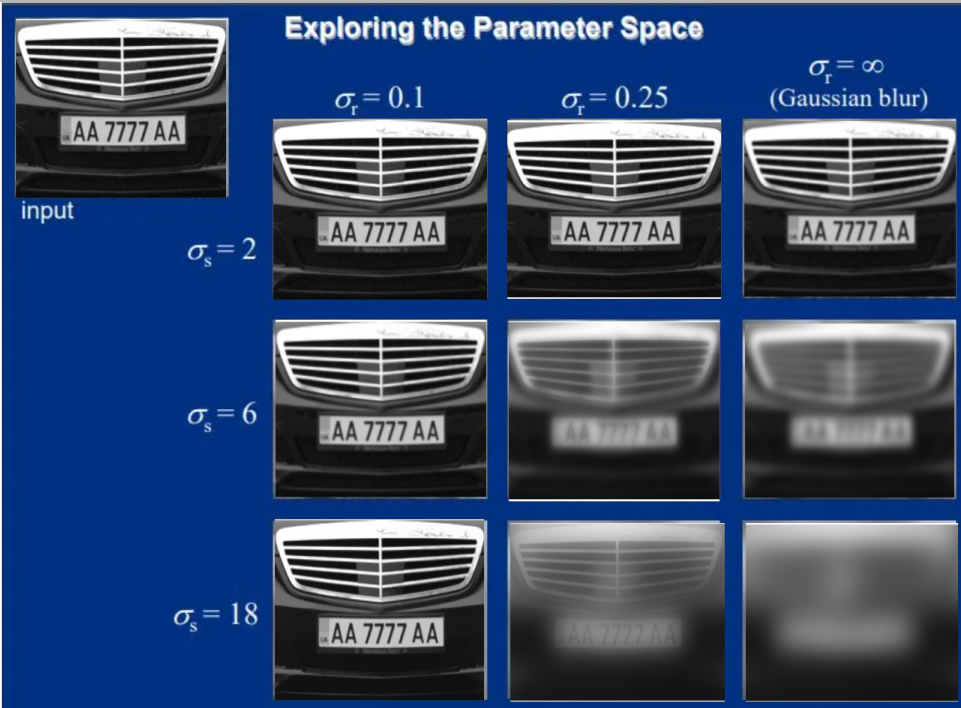

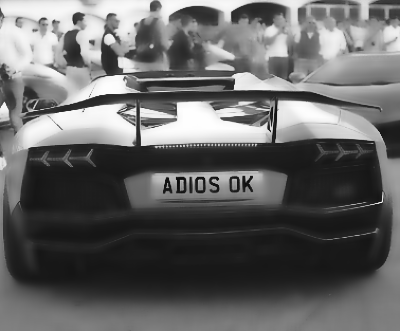

In [6]:
def distance(x1, y1, x2, y2):
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5


def gaussian(x, sigma):
    return 1.0 / (2 * math.pi * (sigma ** 2)) * math.exp(- (x ** 2) / (2 * sigma ** 2))


def use_bilateral(image, filtered_image, x, y, diameter, sigma_i, sigma_s):
    half_diameter = diameter / 2
    i_filtered = 0
    Wei = 0
    for i in range(diameter):
      for j in range(diameter):
            neighbour_x = x - (half_diameter - i)
            neighbour_y = y - (half_diameter - j)

            if neighbour_x >= len(image):
                neighbour_x -= len(image)

            if neighbour_y >= len(image[0]):
                neighbour_y -= len(image[0])

            Gi = gaussian(image[int(neighbour_x)][int(neighbour_y)] - image[int(x)][int(y)], sigma_i)
            Gs = gaussian(distance(neighbour_x, neighbour_y, x, y), sigma_s)

            w = Gi * Gs
            i_filtered += image[int(neighbour_x)][int(neighbour_y)] * w
            Wei += w

    i_filtered = i_filtered / Wei
    filtered_image[x][y] = int(round(i_filtered))


def bilateral(image, diameter, sigma_i, sigma_s):
    filtered_image = np.zeros(np.array(image).shape)

    for i in range(len(image)):
      for j in range(len(image[0])):
        use_bilateral(image, filtered_image, i, j, diameter, sigma_i, sigma_s)

    return filtered_image

img = bilateral(grey_image.tolist(), 10, 50, 100)

cv2_imshow(img)

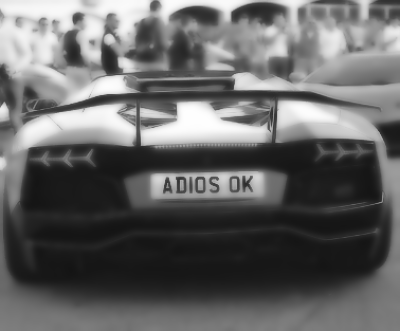

In [7]:
grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

filtered_image_OpenCV = cv2.bilateralFilter(grey_image, 400, 120, 3)
cv2_imshow(filtered_image_OpenCV)

So, we can see that this code work as well as code from openCV library, but is much slower :(

# **Edge detection**

For that part of our project we will use Canny Edge Detector. That algorithm will help us to find main contours on our picture.

This algorithm is composed of 5 steps:

1) Noise reduction

2) Gradient calculation

3) Non-maximum suppression

4) Double threshold

5) Edge Tracking by Hysteresis

**Noise reduction**

This step we have already done using Bilateral Filter


**Gradient Calculation**


The easiest way to detect changes of pixels intensity is to apply filters that highlight this intensity change in both directions: horizontal and vertical.

That`s why for that step we will use Sobel Filter.

When the image is smoothed, the derivatives Ix and Iy w.r.t. x and y are calculated. It can be implemented by convolving I with Sobel kernels Kx and Ky, respectively:

$$K_x=\begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1 
\end{bmatrix}$$

$$K_y= \begin{bmatrix}
1 & 2 & 1 \\
0 & 0 & 0 \\
-1 & -2 & -1 
\end{bmatrix}$$

To get Ix and Iy we have to multiply those matricies on our image. The magnitude G and the slope θ of the gradient are calculated as follow:

$$|G|=\sqrt{I_x^2+I_y^2}$$
$$\theta(x,y)=\arctan(\frac{I_y}{I_x})$$

The magnitude of the image is our result.

**Non-maximum suppression**

The result from the previous step gives us thick edges, but we need to have them thin. Thats why, we must perform non maximum suppression to thin out the edges.

Non maximum suppression works by finding the pixel with the maximum value in an edge. If the pixel has the maximum value in edge direction, then we keep the pixel, otherwise we set the pixel to zero (make it a black pixel).

Non maximum suppression can be achieved by interpolating the pixels for greater accuracy:

$$r=\alpha b + (1-\alpha)a$$

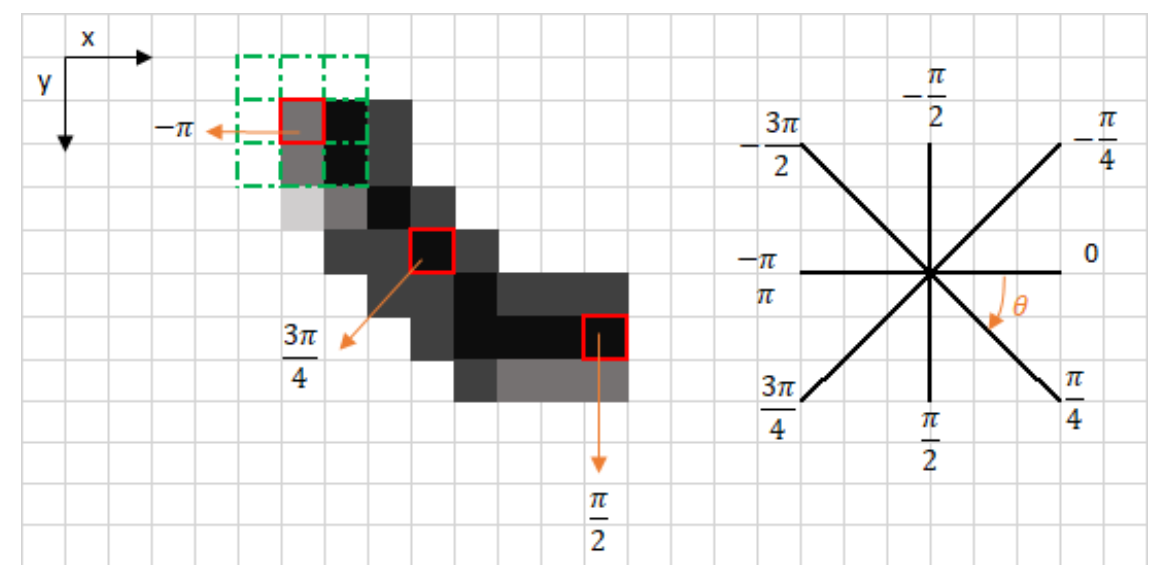

**Double threshold**

The next step is doundle thresholding. Here we are spliting our pixels on 3 categories:

1) pixels which are surely on the edge. We set them white color

2) pixels which are possibly edge pixels. We set them gray color

3) and non edge pixels. We set them black color

We do that using upper and lower tresholds. That means that if the pixel has intensity higher than upper treshold, than it will be white color, because it is from first category. If the pixel has intensity lower that lower treshold it will be black pixel and if pixel is between both tresholds than it will have gray color.

**Edge Tracking by Hysteresis**


In this part, we need to decide whether the weak edges are strong or not. The verification algorithm is actually very simple. We just check to see if the weak edges are touching the strong. If they touch, they are also considered strong, and if not, we simply remove them by painting them black.

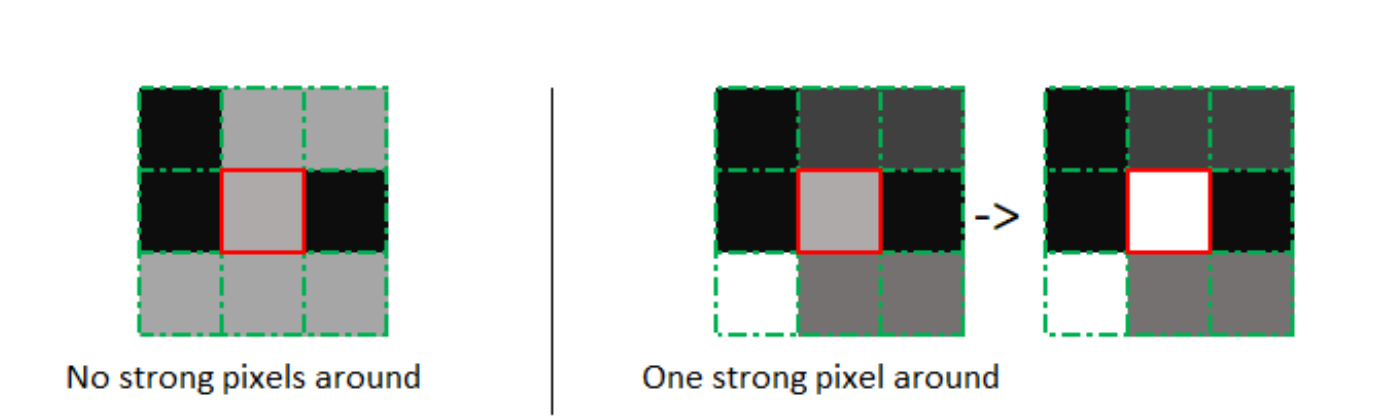

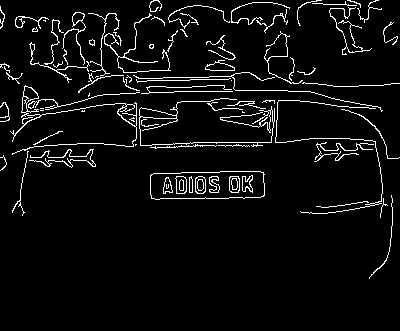

In [8]:
edged = cv2.Canny(filtered_image_OpenCV, 30, 200) 
cv2_imshow(edged)

Now let's apply these contours to our picture to see the result

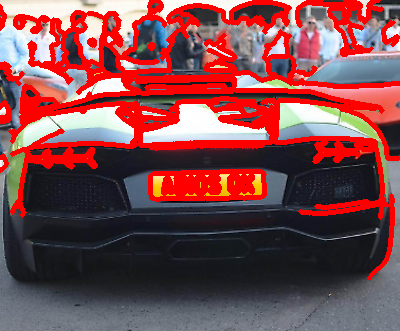

In [9]:
contours = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
new_image = image.copy()
cv2.drawContours(new_image,contours, -1, (0, 0, 255), 3)
cv2_imshow(new_image)

Now it is important for us to choose the largest significant contours, which could potentially be our car numbers.

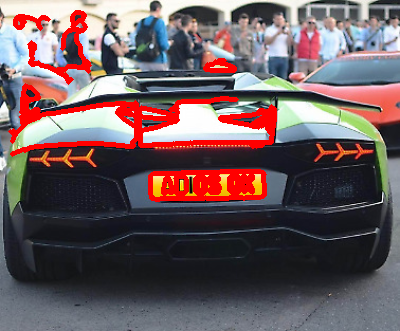

In [10]:
contours = sorted(contours, key = cv2.contourArea, reverse = True) [:30]
screenCnt = None
image_new = image.copy()
cv2.drawContours(image_new, contours, -1, (0, 0, 255), 3)
cv2_imshow(image_new)

now we need to find the largest contour that has all four sides. Because it will have a rectangular shape that could theoretically be our car numbers.


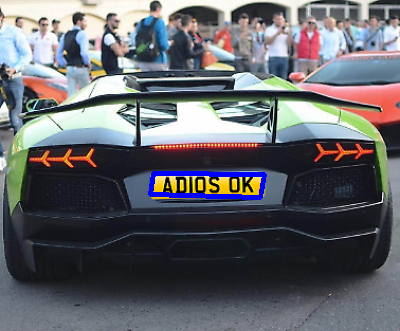

In [11]:
for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        approximate_polygon = cv2.approxPolyDP(contour, 0.018 * perimeter, True)
        if len(approximate_polygon) == 4: 
                center = approximate_polygon
                x, y, width, height = cv2.boundingRect(contour)
                new_img=image[y:y + height, x:x + width]
                cv2.imwrite(f"./result_image.png", new_img)
                break

cv2.drawContours(image, [center], -1, (255, 0, 0), 3)
cv2_imshow(image)

As we can see, our program has successfully found the car numbers in this picture. So let's crop this picture along the outline we found, and using the external pytesseract module, find what exactly is written on them.

In [12]:
final_image = "./result_image.png"
cv2_imshow(cv2.imread(final_image))
plate = pytesseract.image_to_string(final_image, lang="eng")
print(f"Number plate is: {plate}")

Number plate is: 


Overall, we have achieved our aim. We used the right methods (image grayscaling, bilateral filtering and edge detection) to achieve the target. We considered other approaches, such as blurring and Gaussian filtering, that turned out to be worse than the Bilateral filter, which we ended up using.